In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial

import MicroTools as micro
import MicroTools.plot_tools as pt

import param_scan
from tqdm.notebook import tqdm

# 3+1 Oscillation + Decay Scans

In [3]:
def run_scan(kwargs, filename, Npoints=10, path_results = "fit_data/", sin2theta_scan=False):

    # Range of mixings scanned 
    dm_Vec = np.geomspace(np.sqrt(1e-1), np.sqrt(1e5), Npoints)
    g_Vec = np.geomspace(1e-2, 10, Npoints)

    if sin2theta_scan:
        s2thetaSq = np.geomspace(1e-4, 0.5, Npoints)
        Umu4Sq = 0.5
        # Cartesian product of grid -- already imposes unitarity and pertubatirbity of g
        paramlist = param_scan.create_grid_of_params_sin2theta(g=g_Vec, m4=dm_Vec, sin2thetaSq=s2thetaSq, Um4Sq=Umu4Sq)
        
    else:
        Ue4Sq = np.geomspace(1e-3, 0.5, Npoints)
        Umu4Sq = np.geomspace(1e-3, 0.5, Npoints)
        # Cartesian product of grid -- already imposes unitarity and pertubatirbity of g
        paramlist = param_scan.create_grid_of_params(g=g_Vec, m4=dm_Vec, Ue4Sq=Ue4Sq, Um4Sq=Umu4Sq)

    # Pure oscillation method
    func_scan = partial(param_scan.DecayReturnMicroBooNEChi2, **kwargs)

    with Pool() as pool:
        # res = pool.map(func_scan, paramlist)
        res = np.array(list(tqdm(pool.imap(func_scan, paramlist), total=len(paramlist))))

    param_scan.write_pickle(f"{path_results}/{filename}", res)
    return res

In [4]:
# Common attributes to all osc_only scans
kwargs_common = {
    'oscillations': True, 
    'decay': True, 
    'decouple_decay': False, 
    'energy_degradation': True, 
    'include_antineutrinos': True,
    'n_replications': 10}

# Full and Standard case
kwargs_std = {
    'disappearance': True, 
    'use_numu_MC': True,
    'undo_numu_normalization': False,
    **kwargs_common}

In [5]:
PERFORM_SCAN = False
if PERFORM_SCAN:
    n = 2
    _ = run_scan(kwargs_std, 'MH_decay_test_2', Npoints=n)

In [6]:
import MH_decay_scan_run
n = 20
if PERFORM_SCAN:
    _ = MH_decay_scan_run.run_scan_gfixed_Ue4SQRfixed(
        MH_decay_scan_run.kwargs_std,
        "MH_decay_gfixed_2.5_Ue4SQRfixed_0.05",
        Npoints=n,
        gfixed=2.5,
        Ue4SQRfixed=0.05,
    )

    _ = MH_decay_scan_run.run_scan_gfixed_Ue4SQRfixed(
        MH_decay_scan_run.kwargs_std,
        "MH_decay_gfixed_2.5_Ue4SQRfixed_0.10",
        Npoints=n,
        gfixed=2.5,
        Ue4SQRfixed=0.10,
    )

    _ = MH_decay_scan_run.run_scan_gfixed_Ue4SQRfixed(
        MH_decay_scan_run.kwargs_std,
        "MH_decay_gfixed_2.5_Ue4SQRfixed_0.01",
        Npoints=n,
        gfixed=2.5,
        Ue4SQRfixed=0.01,
    )

In [7]:
def load_scan_data(filename, wi=None, w_fixed=None):
    data = param_scan.pickle_read(filename)
    
    if wi is not None:
        cut_in_w = data[np.argmin(np.abs(data[:,wi] - w_fixed)), wi]
        data = data[(data[:,wi] == cut_in_w)]
    
    data_dic = {}
    data_dic['g'] = data[:,0]
    data_dic['m4'] = data[:,1]
    data_dic['Ue4SQR'] = data[:,2]
    data_dic['Umu4SQR'] = data[:,3]
    s2t = 4*data_dic['Ue4SQR']*data_dic['Umu4SQR']
    data_dic['sin2theta'] = np.round(s2t, decimals=6)
    data_dic['dm4SQR'] = data[:,1]**2
    
    data_dic['MiniApp_chi2'] =  data[:,-3]
    data_dic['MicroApp_chi2'] =  data[:,-2]
    data_dic['MicroApp_Asimov_chi2'] = data[:,-1] 

    data_dic['MiniApp_deltachi2'] = data_dic['MiniApp_chi2'] - np.min(data_dic['MiniApp_chi2'])
    data_dic['MicroApp_deltachi2'] = data_dic['MicroApp_chi2'] - np.min(data_dic['MicroApp_chi2'])
    data_dic['MicroApp_Asimov_deltachi2'] = data_dic['MicroApp_Asimov_chi2'] - np.min(data_dic['MicroApp_Asimov_chi2'])

    return data_dic


In [8]:
def profile_for_sin2theta(data_dic):
    dic_prof = {}
    # Profile each chi2
    dic_prof['sin2theta'], dic_prof['dm4SQR'], dic_prof['MiniApp_chi2'] = param_scan.profile_in_plane(data_dic['sin2theta'], data_dic['dm4SQR'], data_dic['MiniApp_chi2'])
    dic_prof['sin2theta'], dic_prof['dm4SQR'], dic_prof['MicroApp_chi2'] = param_scan.profile_in_plane(data_dic['sin2theta'], data_dic['dm4SQR'], data_dic['MicroApp_chi2'])
    dic_prof['sin2theta'], dic_prof['dm4SQR'], dic_prof['MicroApp_Asimov_chi2'] = param_scan.profile_in_plane(data_dic['sin2theta'], data_dic['dm4SQR'], data_dic['MicroApp_Asimov_chi2'])
    return dic_prof


def profile_for_Umu4SQR(data_dic):
    dic_prof = {}
    # Profile each chi2
    dic_prof['Umu4SQR'], dic_prof['dm4SQR'], dic_prof['MiniApp_chi2'] = param_scan.profile_in_plane(data_dic['Umu4SQR'], data_dic['dm4SQR'], data_dic['MiniApp_chi2'])
    dic_prof['Umu4SQR'], dic_prof['dm4SQR'], dic_prof['MicroApp_chi2'] = param_scan.profile_in_plane(data_dic['Umu4SQR'], data_dic['dm4SQR'], data_dic['MicroApp_chi2'])
    dic_prof['Umu4SQR'], dic_prof['dm4SQR'], dic_prof['MicroApp_Asimov_chi2'] = param_scan.profile_in_plane(data_dic['Umu4SQR'], data_dic['dm4SQR'], data_dic['MicroApp_Asimov_chi2'])
    return dic_prof


In [9]:
data_full = load_scan_data('fit_data/MH_decay_test_30.pkl')
dic_full_prof = profile_for_sin2theta(data_full)
dic_g_one_prof = profile_for_sin2theta(load_scan_data('fit_data/MH_decay_test_30.pkl', wi=0, w_fixed=1))
dic_g_twofive_prof = profile_for_sin2theta(load_scan_data('fit_data/MH_decay_test_30.pkl', wi=0, w_fixed=2.5))

dic_Ue4sqr_solar_prof = profile_for_sin2theta(load_scan_data('fit_data/MH_decay_test_30.pkl', wi=2, w_fixed=0.05))
dic_Ue4sqr_BEST_prof = profile_for_sin2theta(load_scan_data('fit_data/MH_decay_test_30.pkl', wi=2, w_fixed=0.1))


data_full_gfixed_2p5 = load_scan_data('fit_data/MH_decay_gfixed_2.5_30.pkl')
data_full_gfixed_2p5 = profile_for_Umu4SQR(data_full_gfixed_2p5)
data_full_gfixed_2p5_solar_prof = profile_for_Umu4SQR(load_scan_data('fit_data/MH_decay_gfixed_2.5_30.pkl', wi=2, w_fixed=0.05))
data_full_gfixed_2p5_best_prof = profile_for_Umu4SQR(load_scan_data('fit_data/MH_decay_gfixed_2.5_30.pkl', wi=2, w_fixed=0.1))


In [10]:
data_full_gfixed_2p5_solar = profile_for_Umu4SQR(load_scan_data('fit_data/MH_decay_gfixed_2.5_Ue4SQRfixed_0.05.pkl'))
data_full_gfixed_2p5_best = profile_for_Umu4SQR(load_scan_data('fit_data/MH_decay_gfixed_2.5_Ue4SQRfixed_0.10.pkl'))
data_full_gfixed_2p5_001 = profile_for_Umu4SQR(load_scan_data('fit_data/MH_decay_gfixed_2.5_Ue4SQRfixed_0.01.pkl'))

### Mixing vs dm4 (fixed other)

'$1 \\sigma$$2 \\sigma$$3 \\sigma$$4 \\sigma$'

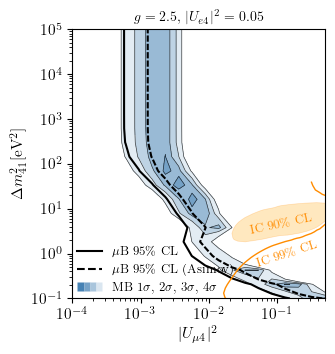

In [346]:
def make_sin2thetaemu_plot(dic, name='default', suffix='default', cmap_color='steelblue', n_sigmas=4):
    fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
    ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
    ax1.set_title(name, fontsize=10)
    ax1.set_xlim(1e-6,0.2)
    

    kwargs_interp = {'fine_gridx': len(np.unique(dic['sin2theta'])),  
                    'fine_gridy': len(np.unique(dic['dm4SQR'])), 
                    'logx':True, 
                    'logy':True}
    X, Y, Z = pt.interp_grid(dic['sin2theta'], dic['dm4SQR'], dic['MiniApp_chi2']-np.min(dic['MiniApp_chi2']), **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 3), colors=['tomato','darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
    cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 3), colors=['black','black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)
    # ax1.scatter(app_dic['sin2theta'], app_dic['dm4SQR'])

    X, Y, Z = pt.interp_grid(dic['sin2theta'], dic['dm4SQR'], dic['MicroApp_chi2']-np.min(dic['MicroApp_chi2']), **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], 2), colors=['black'], zorder=2)

    X, Y, Z = pt.interp_grid(dic['sin2theta'], dic['dm4SQR'], dic['MicroApp_Asimov_chi2']-np.min(dic['MicroApp_Asimov_chi2']), **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], 2), colors=['black'], linestyles=[(1,(3,1))], zorder=2)

    ax1.fill([], [], edgecolor='black', facecolor='tomato', lw=0.25, label='MB ($1 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($2 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($3 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($4 \sigma$)')
    ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
    ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B 95\% CL (Asimov)')


    ax1.legend(loc=(0,0), fontsize=9)
    # fig.savefig(f"{micro.path_plots}/MH_full_osc_sin2thetaemuSQR_profiled.pdf", bbox_inches='tight', dpi=300)
    fig.savefig(f"{micro.path_plots}/MH_decay_sin2thetaemuSQR_profiled_{suffix}.pdf", bbox_inches='tight', dpi=300)


def make_Umu4SQR_plot(dic, name='default', suffix='default',plot_IC=False, cmap_color='steelblue', n_sigmas=4, cmin=0, cmax=1):
    fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
    ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
    ax1.set_title(name, fontsize=10)
    ax1.set_xlim(1e-4,0.5)
    # ax1.set_ylim(1e-1,100)
    

    kwargs_interp = {'fine_gridx': len(np.unique(dic['Umu4SQR'])),  
                    'fine_gridy': len(np.unique(dic['dm4SQR'])), 
                    'logx':True, 
                    'logy':True,
                    'method': 'interpolate',
                    }
    
    colors = pt.get_cmap_colors(cmap_color, n_sigmas, cmin=cmin, cmax=cmax)
    X, Y, Z = pt.interp_grid(dic['Umu4SQR'], dic['dm4SQR'], dic['MiniApp_chi2']-np.min(dic['MiniApp_chi2']), **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 2), colors=colors, zorder=1, alpha=0.75)
    cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 2), colors=['black'], linewidths=0.5, zorder=1, alpha=0.75)
    # ax1.scatter(dic['Umu4SQR'], dic['dm4SQR'], c=np.log10(dic['MiniApp_chi2']-np.min(dic['MiniApp_chi2'])),)

    X, Y, Z = pt.interp_grid(dic['Umu4SQR'], dic['dm4SQR'], dic['MicroApp_chi2']-np.min(dic['MicroApp_chi2']), **kwargs_interp)
    # cs = ax1.contourf(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], 2)+[np.inf], edgecolors=['None'], colors=['grey'], zorder=2)
    cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], 2), colors=['black'], zorder=2)

    X, Y, Z = pt.interp_grid(dic['Umu4SQR'], dic['dm4SQR'], dic['MicroApp_Asimov_chi2']-np.min(dic['MicroApp_Asimov_chi2']), **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], 2), colors=['black'], linestyles=[(1,(3,1))], zorder=2)

    ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
    ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B 95\% CL (Asimov)')
    
    # ------ get the legend-entries that are already attached to the axis
    h, l = ax1.get_legend_handles_labels()
    h.append(pt.MulticolorPatch(colors))
    mb_label = 'MB '+', '.join([fr'${i+1} \sigma$' for i in range(n_sigmas)])
    l.append(mb_label)

    if plot_IC:
        x, y = np.genfromtxt('MicroTools/osc_data/IceCube_2022_sterile_decay_90CL.dat', unpack=True)
        x,y = pt.get_ordered_closed_region([x,y], logx=True, logy=True)
        ax1.fill(x, y, facecolor='orange', edgecolor='darkorange', lw=0.5, ls='-', alpha=0.25, hatch='')
        ax1.annotate('IC 90\% CL', xy=(0.038, 2.8), xycoords='data', rotation=12, color='darkorange', fontsize=9)
        ax1.annotate('IC 99\% CL', xy=(0.048, 0.5), xycoords='data', rotation=18, color='darkorange', fontsize=9)
        x, y = np.genfromtxt('MicroTools/osc_data/IceCube_2022_sterile_decay_99CL.dat', unpack=True)
        ax1.plot(x, y, color='darkorange', lw=1, ls='-', alpha=1,zorder=4)

    ax1.legend(h, l, loc=(0,0), fontsize=9, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()})
    fig.savefig(f"{micro.path_plots}/MH_decay_Umu4SQR_profiled_{suffix}.pdf", bbox_inches='tight', dpi=300)

make_Umu4SQR_plot(data_full_gfixed_2p5_solar, name=r'$g = 2.5$, $|U_{e 4}|^2 = 0.05$', suffix='gfixed_2p5_solar', plot_IC=True, n_sigmas=4, cmap_color='steelblue', cmax=0.8)


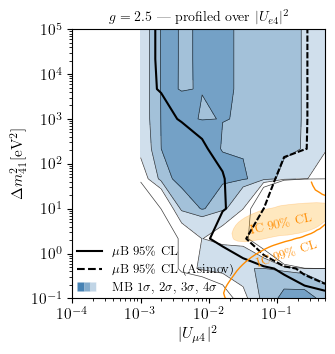

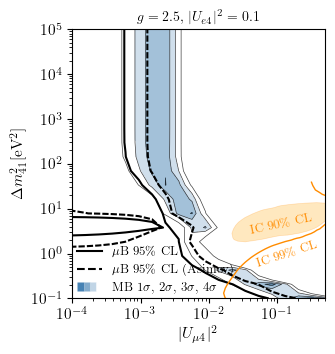

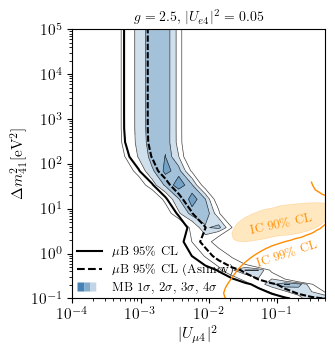

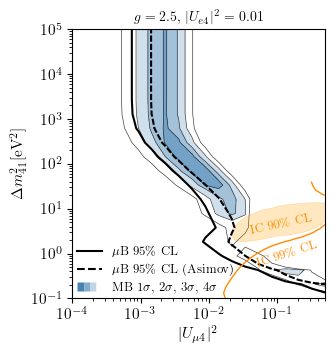

In [347]:
color = 'steelblue'
make_Umu4SQR_plot(data_full_gfixed_2p5, name=r'$g = 2.5$ | profiled over $|U_{e4}|^2$', suffix='gfixed_2p5', plot_IC=True, n_sigmas=4, cmap_color=color)
make_Umu4SQR_plot(data_full_gfixed_2p5_best, name=r'$g = 2.5$, $|U_{e 4}|^2 = 0.1$', suffix='gfixed_2p5_best', plot_IC=True, n_sigmas=4, cmap_color=color)
make_Umu4SQR_plot(data_full_gfixed_2p5_solar, name=r'$g = 2.5$, $|U_{e 4}|^2 = 0.05$', suffix='gfixed_2p5_solar', plot_IC=True, n_sigmas=4, cmap_color=color)
make_Umu4SQR_plot(data_full_gfixed_2p5_001, name=r'$g = 2.5$, $|U_{e 4}|^2 = 0.01$', suffix='gfixed_2p5_small', plot_IC=True, n_sigmas=4, cmap_color=color)

In [311]:
labels_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
string_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
def get_var(data, i):
    if i == 1:
        return data[:,1]**2
    return data[:,i]

def plot_all_slices(filename, xi=2, yi=3, zi=1, wi=0, w_fixed=1, global_deltachi2=False, n_sigmas=4, cmap_color='steelblue'):
    data = param_scan.pickle_read(f"fit_data/{filename}.pkl")
    cut_in_w = data[np.argmin(np.abs(data[:,wi] == w_fixed)), wi]
    data = data[(data[:,wi] == cut_in_w)]
    
    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 
    
    x, y, z, w = get_var(data,xi), get_var(data,yi), get_var(data,zi), get_var(data,wi)
    i_min = np.argmin(MiniApp_chi2)
    x_min, y_min, z_min = x[i_min], y[i_min], z[i_min]
    
    z_slices = np.geomspace(np.min(z), np.max(z),9,endpoint=True)
    if z_min not in z_slices:
        z_slices = np.delete(z_slices, np.argmin(np.abs(z_slices - z_min)))
        z_slices = np.append(z_slices, z_min)
    z_slices = np.sort(z_slices)
    
    fig, axs = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True)
    # plt.subplots_adjust(hspace=0, wspace=0)
    axs = axs.flatten()
    for i, z_slice in enumerate(z_slices):
        z_slice_true = z[np.argmin(np.abs(z - z_slice))]
        cut = (z == z_slice_true)

        ax = axs[i]
        ax.set_xscale('log')
        ax.set_yscale('log')
        if i in [0,3,6]:
            ax.set_ylabel(string_slices[yi], fontproperties=pt.font)
        # else:
            # ax.set_yticklabels([])
            
        if i in [6,7,8]:
            ax.set_xlabel(string_slices[xi], fontproperties=pt.font)
        else:
            ax.set_xticklabels([])
        ax.annotate(text=fr"{string_slices[zi]} $\,= {z_slice_true:.3f}$", 
                    xycoords='axes fraction', 
                    xy=(0.05,0.9), 
                    fontsize=11, 
                    bbox=dict(facecolor='white', edgecolor='None', alpha=0.9, boxstyle='round'))

        le = len(np.unique(x))
        kwargs_interp = {'fine_gridx': le,  
                        'fine_gridy': le, 
                        'logx':True, 
                        'logy':True,
                        }

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2[cut]), **kwargs_interp)
        
        colors = pt.get_cmap_colors(cmap_color, n_sigmas, xmin=0.1, xmax=0.9)
        cs = ax.contourf(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 2), colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, 2), colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2[cut]), **kwargs_interp)
        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL(0.95, 2), colors=['black'], zorder=2)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2[cut]), **kwargs_interp)
        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL(0.95, 2), colors=['black'], linestyles=[(1,(3,1))], zorder=2)
        if z_min == z_slice:
            ax.scatter(x_min, y_min, marker='*', color='black',)
        ax.tick_params(axis="both", which='both', direction="inout", left="off", labelleft="on")
        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(y.min(), y.max())
        if i == 0:
            h, l = ax.get_legend_handles_labels()
            h.append(pt.MulticolorPatch(colors))
            mb_label = 'MB '+', '.join([fr'${i+1} \sigma$' for i in range(n_sigmas)])
            l.append(mb_label)
            ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
            ax.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B 95\% CL (Asimov)')

            ax.legend(h, l, loc=(0,0), fontsize=9, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()})
    fig.suptitle(fr'{string_slices[wi]} $\,= {w_fixed:.2f}$')
    fig.savefig(f"{micro.path_plots}/{filename}_allslices_{xi}_{yi}_{zi}_{wi}_{w_fixed:.3f}{'_global' if global_deltachi2 else ''}.pdf", bbox_inches='tight', dpi=300)



### Ue4 vs dm4 (profile over Umu4)

In [351]:
labels_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
string_slices = [r'$g_\varphi$',r'$\Delta m_{41}^2$', r"$|U_{e 4}|^2$", r"$|U_{\mu 4}|^2$", r"$\sin^2(2\theta_{\mu e})$"]
def get_var(data, i):
    if i == 1:
        return data[:,1]**2
    return data[:,i]

def plot_all_slices(filename, xi=2, yi=3, zi=1, z_range=None, wi=0, w_fixed=1, global_deltachi2=False, n_sigmas=4, cmap_color='steelblue'):
    data = param_scan.pickle_read(f"fit_data/{filename}.pkl")
    cut_in_w = data[np.argmin(np.abs(data[:,wi] - w_fixed)), wi]
    data = data[(data[:,wi] == cut_in_w)]

    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 
    
    x, y, z, w = get_var(data,xi), get_var(data,yi), get_var(data,zi), get_var(data, wi)
    i_min = np.argmin(MiniApp_chi2)
    x_min, y_min, z_min = x[i_min], y[i_min], z[i_min]
    if z_range is not None:
        z_slices = np.geomspace(z_range[0], z_range[1], 9,endpoint=True)
    else:
        z_slices = np.geomspace(np.min(z), np.max(z),9,endpoint=True)

    if z_min not in z_slices:
        z_slices = np.delete(z_slices, np.argmin(np.abs(z_slices - z_min)))
        z_slices = np.append(z_slices, z_min)
    z_slices = np.sort(z_slices)
    
    fig, axs = plt.subplots(3, 3, figsize=(8, 8), sharex=False, sharey=False, constrained_layout=False)
    plt.subplots_adjust(hspace=0.075, wspace=0.05)
    axs = axs.flatten()
    for i, z_slice in enumerate(z_slices):
        z_slice_true = z[np.argmin(np.abs(z - z_slice))]
        cut = (z == z_slice_true)

        ax = axs[i]
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.tick_params(axis="both", which='both', direction="inout", left="off", labelleft="on", zorder=10)
        # ax.set_xticklabels(fontsize=13)
        # ax.set_yticklabels(fontsize=13)

        ax.set_xlim(x.min(), x.max())
        ax.set_ylim(y.min(), y.max())

        if i in [0,3,6]:
            ax.set_ylabel(string_slices[yi], fontproperties=pt.font, fontsize=13)
        else:
            ax.set_yticklabels([])
            
        if i in [6,7,8]:
            ax.set_xlabel(string_slices[xi], fontproperties=pt.font, fontsize=13)
        else:
            ax.set_xticklabels([])

        fixed_value = fr"{string_slices[zi]} \,$= {pt.sci_notation(z_slice_true, sig_digits=2, notex=True, optional_sci=3)}$"
        if zi == 1:
            fixed_value += r"\, eV$^2$"
        ax.annotate(text=fixed_value, 
                    xycoords='axes fraction', 
                    xy=(0.05,0.86), 
                    fontsize=13, 
                    bbox=dict(facecolor='white', edgecolor='None', alpha=0.9, boxstyle='round'))

        kwargs_interp = {   'fine_gridx': len(np.unique(x)),  
                            'fine_gridy': len(np.unique(y)), 
                            'logx':True, 
                            'logy':True,
                        }

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2), **kwargs_interp)
            ndof = 3
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MiniApp_chi2[cut]-np.min(MiniApp_chi2[cut]), **kwargs_interp)
            ndof = 2
        
        colors = pt.get_cmap_colors(cmap_color, n_sigmas, cmin=0.0, cmax=0.9)
        cs = ax.contourf(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, ndof), colors=colors, zorder=1, alpha=0.75)
        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_nsigmas(n_sigmas, ndof), colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)
        ax.scatter(X.flatten()[np.argmin(Z)], Y.flatten()[np.argmin(Z)], marker='*', facecolor='white', edgecolor='black', lw=0.5, zorder=10)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_chi2[cut] - np.min(MicroApp_chi2[cut]), **kwargs_interp)
        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], ndof), colors=['black'], zorder=2)

        if global_deltachi2:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2), **kwargs_interp)
        else:
            X, Y, Z = pt.interp_grid(x[cut], y[cut], MicroApp_Asimov_chi2[cut] - np.min(MicroApp_Asimov_chi2[cut]), **kwargs_interp)

        cs = ax.contour(X,Y,Z, levels=pt.get_chi2vals_w_CL([0.95], ndof), colors=['black'], linestyles=[(1,(3,1))], zorder=2)
        if z_min == z_slice:
            ax.scatter(x_min, y_min, marker='*', facecolor='black', edgecolor='black', lw=0.25, zorder=10)
        if i == 0:
            h, l = ax.get_legend_handles_labels()
            h.append(pt.MulticolorPatch(colors))
            mb_label = 'MB '+', '.join([fr'${i+1} \sigma$' for i in range(n_sigmas)])
            l.append(mb_label)
            ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
            ax.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B 95\% CL (Asimov)')
            ax.legend(h, l, loc=(0,0), fontsize=9, handler_map={pt.MulticolorPatch: pt.MulticolorPatchHandler()})
    nstring = r'n_{\rm dof}'
    ndof = rf' $\vert$ ${nstring} = {ndof}$'
    axs[1].annotate(text=fr"{string_slices[wi]} $\,= {w_fixed:.2f}${ndof}", xycoords='axes fraction', xy=(0.5,1.075), fontsize=14, ha='center', zorder=10)
    fig.savefig(f"{micro.path_plots}/MH_decay_allslices_{xi}_{yi}_{zi}_{wi}_{w_fixed:.3f}{'_global' if global_deltachi2 else ''}.pdf", bbox_inches='tight', dpi=300)



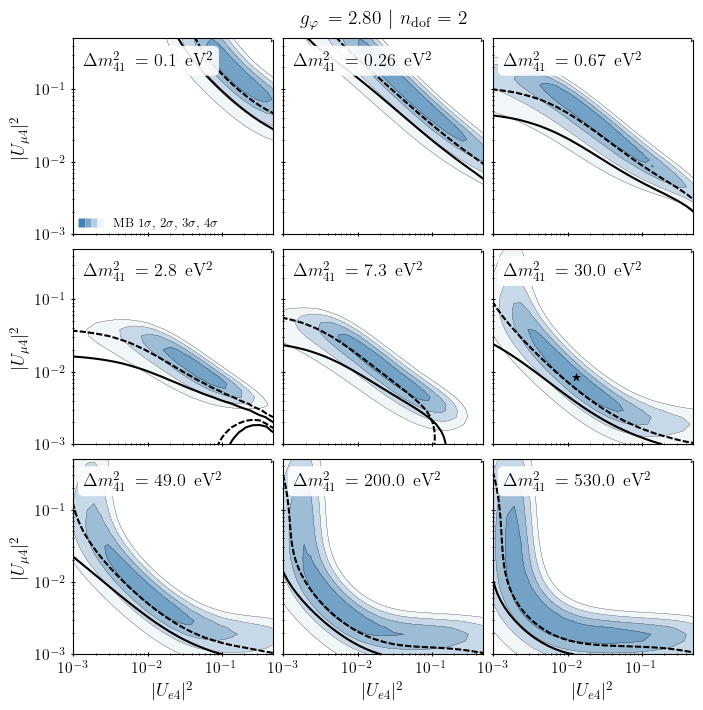

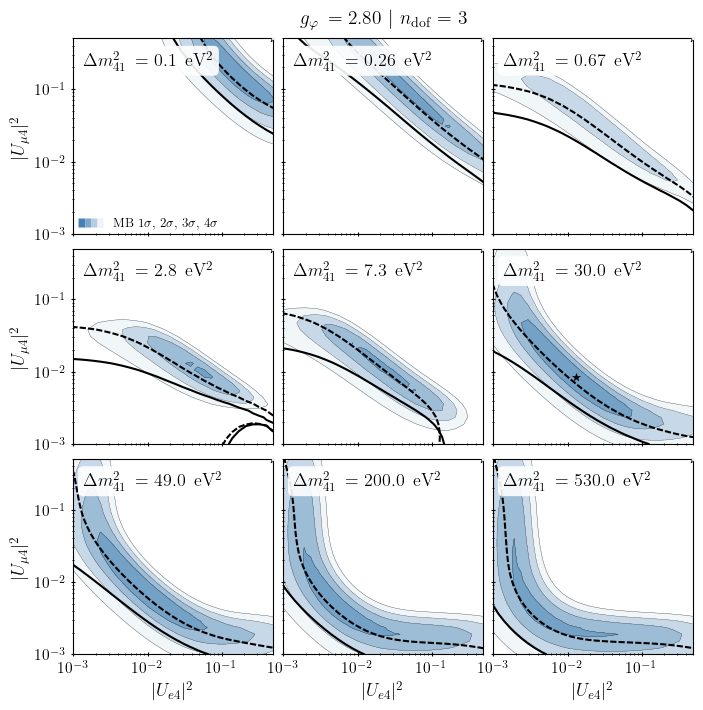

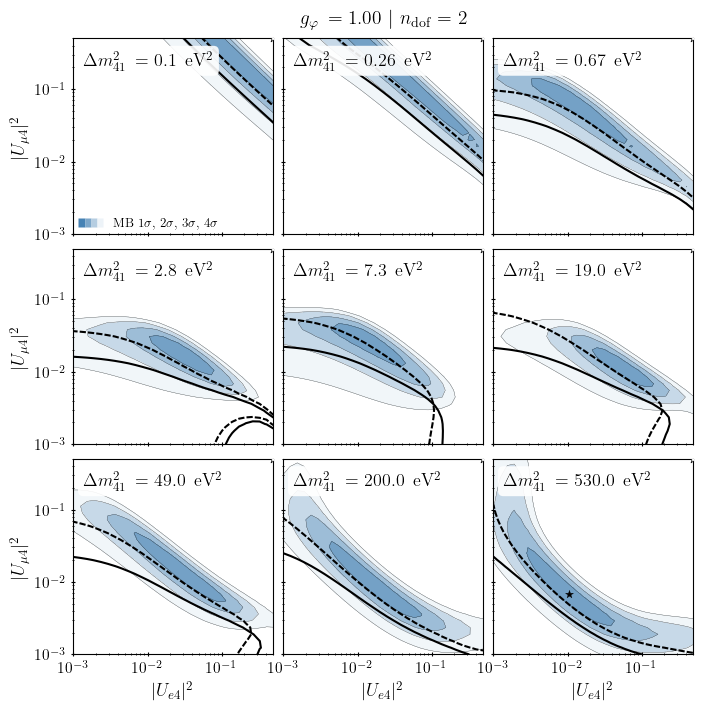

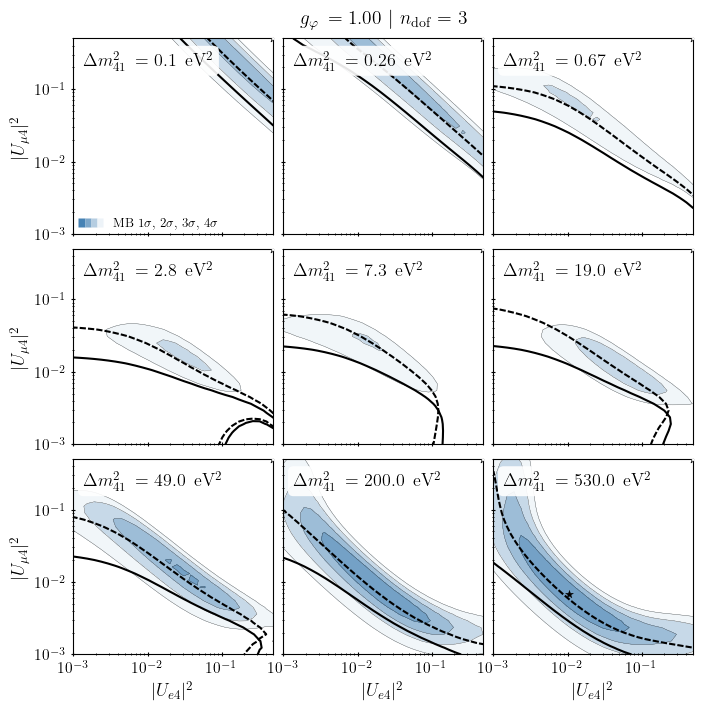

In [352]:
plot_all_slices('MH_decay_test_30', xi=2, yi=3, zi=1, z_range=[0.1, 500], wi=0, w_fixed=2.8, global_deltachi2=False)
plot_all_slices('MH_decay_test_30', xi=2, yi=3, zi=1, z_range=[0.1, 500], wi=0, w_fixed=2.8, global_deltachi2=True)

plot_all_slices('MH_decay_test_30', xi=2, yi=3, zi=1, z_range=[0.1, 500], wi=0, w_fixed=1, global_deltachi2=False)
plot_all_slices('MH_decay_test_30', xi=2, yi=3, zi=1, z_range=[0.1, 500], wi=0, w_fixed=1, global_deltachi2=True)


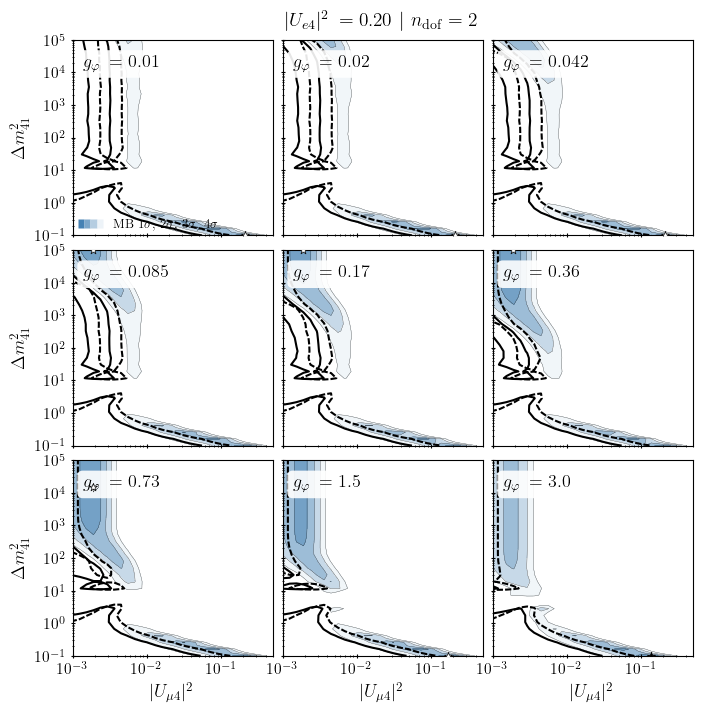

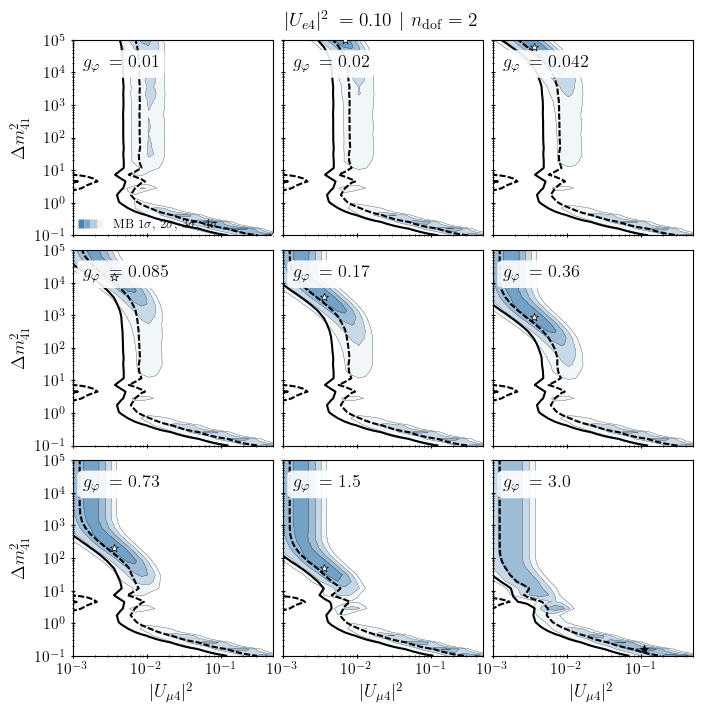

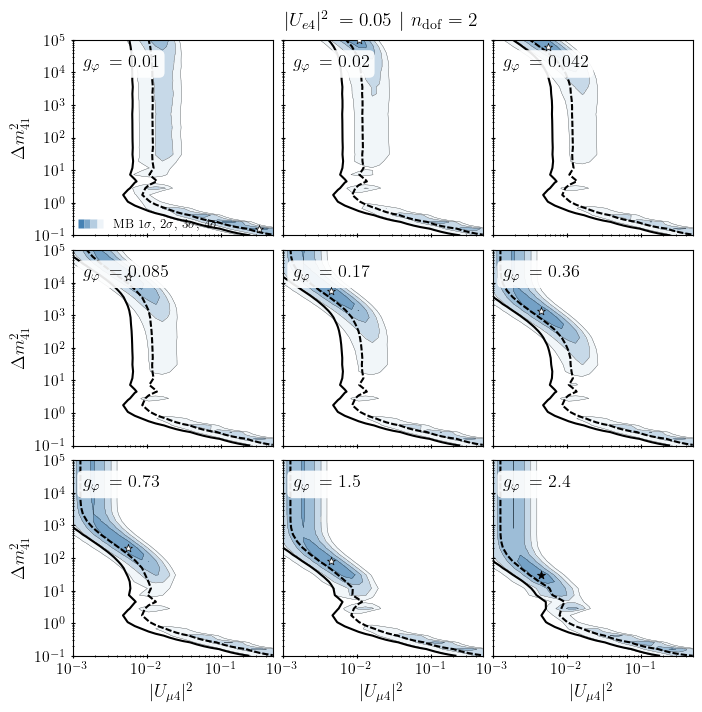

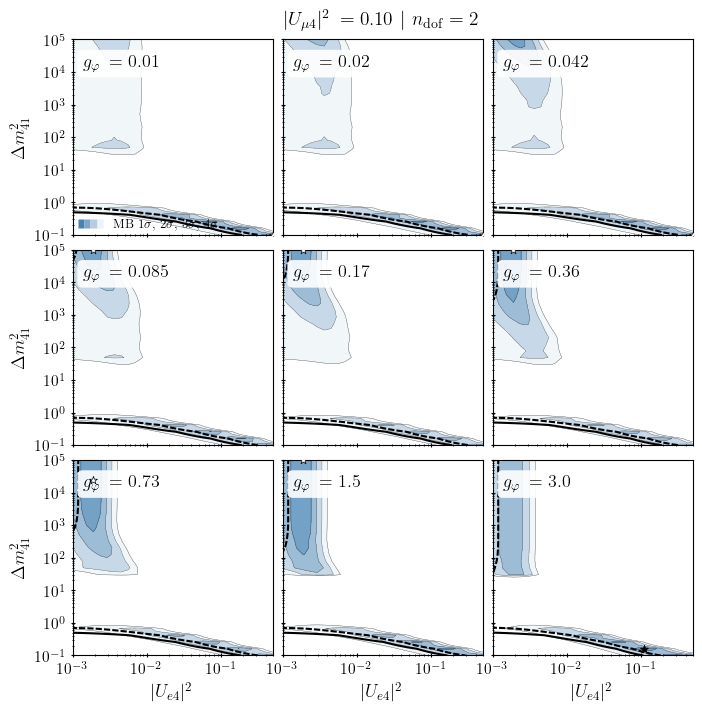

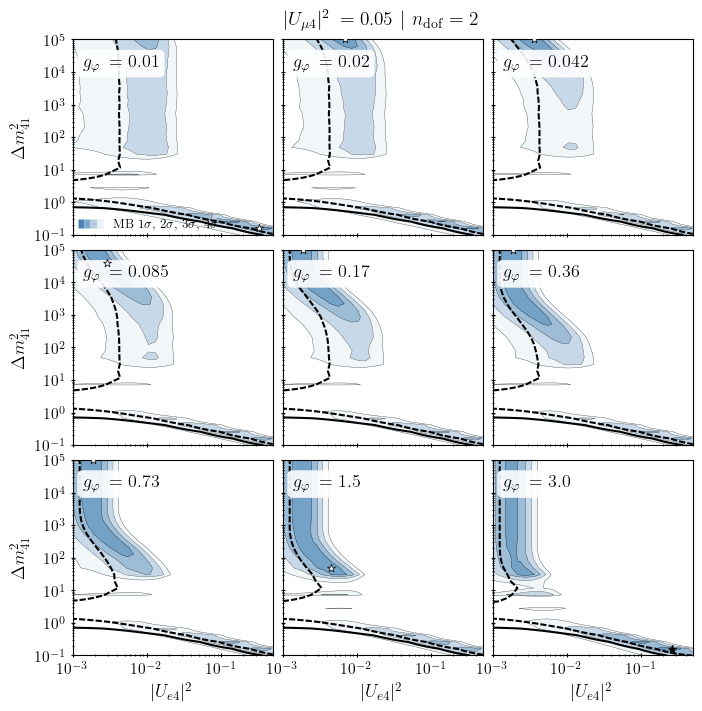

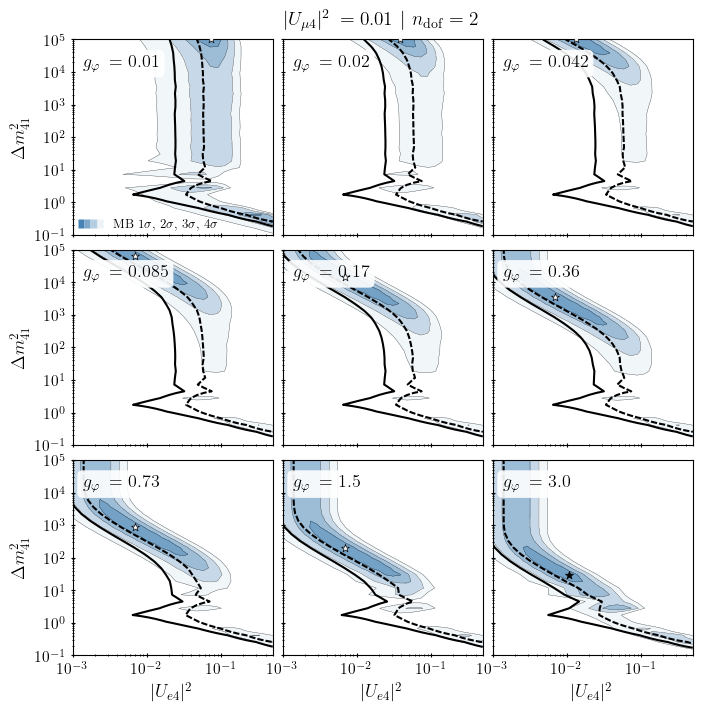

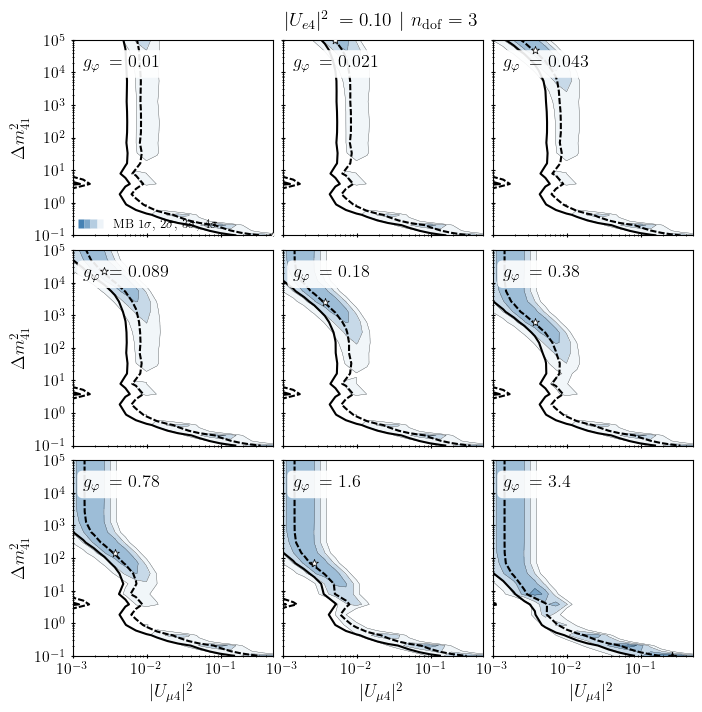

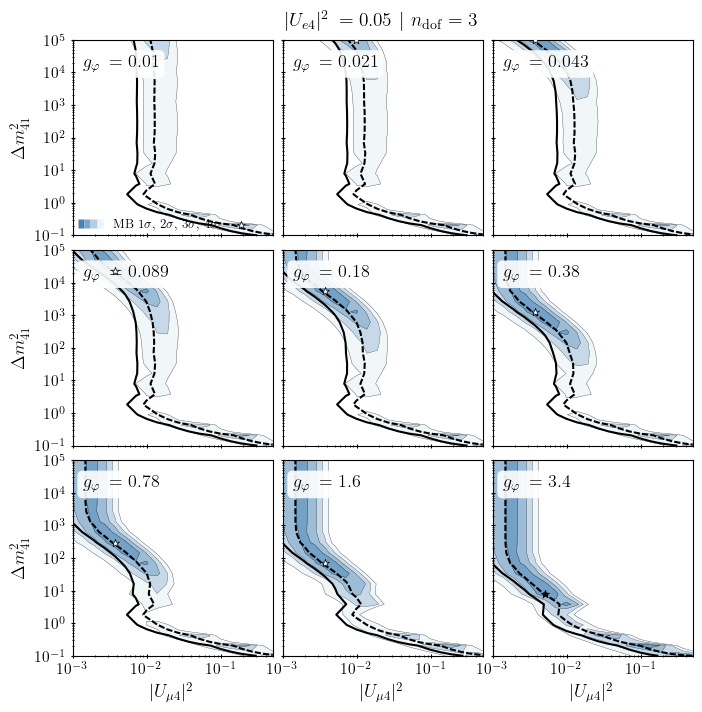

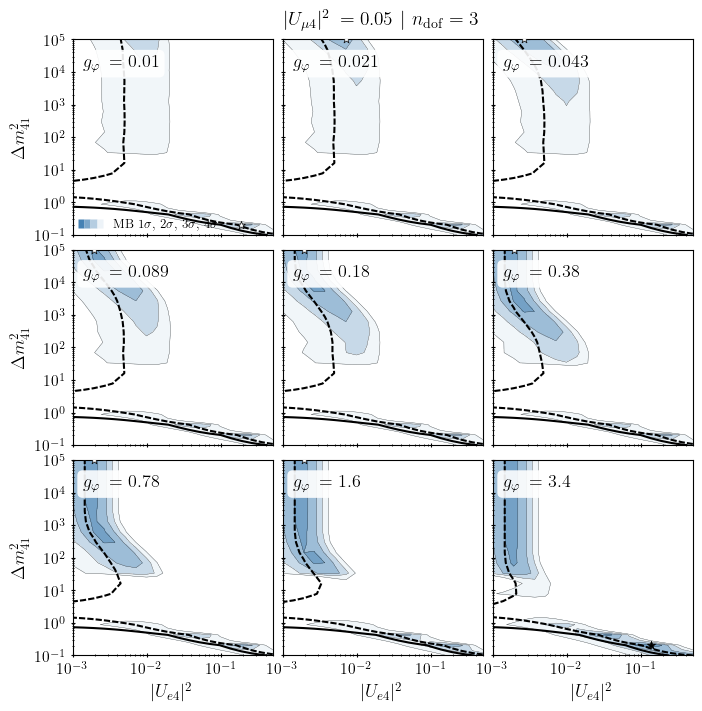

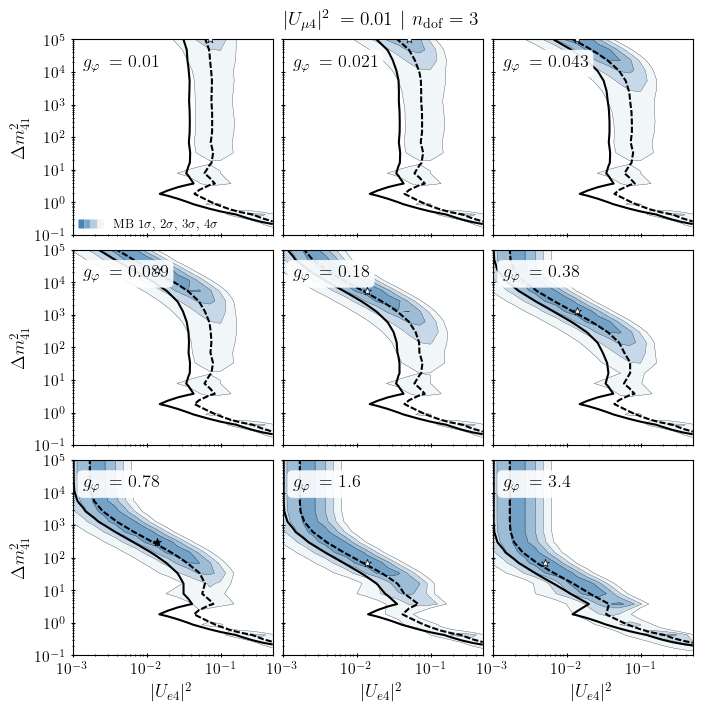

In [353]:
plot_all_slices('MH_decay_test_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.2, global_deltachi2=False)
plot_all_slices('MH_decay_test_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.1, global_deltachi2=False)
plot_all_slices('MH_decay_test_30', xi=3, yi=1, zi=0, wi=2, w_fixed=0.05, global_deltachi2=False)

plot_all_slices('MH_decay_test_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.1, global_deltachi2=False)
plot_all_slices('MH_decay_test_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.05, global_deltachi2=False)
plot_all_slices('MH_decay_test_30', xi=2, yi=1, zi=0, wi=3, w_fixed=0.01, global_deltachi2=False)


plot_all_slices('MH_decay_test', xi=3, yi=1, zi=0, wi=2, w_fixed=0.1, global_deltachi2=True)
plot_all_slices('MH_decay_test', xi=3, yi=1, zi=0, wi=2, w_fixed=0.05, global_deltachi2=True)
plot_all_slices('MH_decay_test', xi=2, yi=1, zi=0, wi=3, w_fixed=0.05, global_deltachi2=True)
plot_all_slices('MH_decay_test', xi=2, yi=1, zi=0, wi=3, w_fixed=0.01, global_deltachi2=True)

### Umu4 vs dm4 (profile over Ue4)

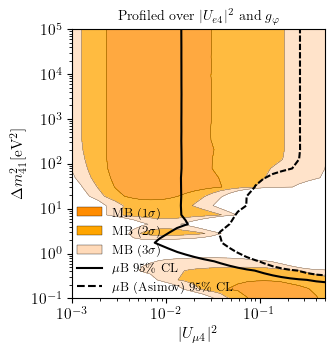

In [127]:
filenames = ['MH_decay_test_30']
for filename in filenames:
    data = param_scan.pickle_read(f"fit_data/{filename}.pkl")

    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 

    
    MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
    MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
    MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

    Ue4SQR, Umu4SQR, dm4SQR = data[:,2], data[:,3], data[:,1]**2

    # Profile each chi2
    prof_x, prof_y, prof_MiniApp_deltachi2 = param_scan.profile_in_plane(Umu4SQR, dm4SQR, MiniApp_deltachi2)
    prof_x_mu, prof_y_mu, prof_MicroApp_deltachi2 = param_scan.profile_in_plane(Umu4SQR, dm4SQR, MicroApp_deltachi2)
    prof_x_mu_asimov, prof_y_mu_asimov, prof_MicroApp_Asimov_deltachi2 = param_scan.profile_in_plane(Umu4SQR, dm4SQR, MicroApp_Asimov_deltachi2)

    fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
    xmin, xmax, ymin, ymax = 1e-4, 3e-2, 1e-1, 1e2
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    # ax1.axis([xmin, xmax, ymin, ymax])
    # ax1.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
    # ax1.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
    ax1.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
    ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
    ax1.set_title(fr"Profiled over $|U_{{e 4}}|^2$ and $g_\varphi$", fontsize=10)

    le = len(np.unique(Umu4SQR))
    kwargs_interp = {'fine_gridx': le,  
                            'fine_gridy': le, 
                            'logx':True, 
                            'logy':True,
                            }

    X, Y, Z = pt.interp_grid(prof_x, prof_y, prof_MiniApp_deltachi2, **kwargs_interp)
    cs = ax1.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
    cs = ax1.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

    X, Y, Z = pt.interp_grid(prof_x_mu, prof_y_mu, prof_MicroApp_deltachi2, **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

    X, Y, Z = pt.interp_grid(prof_x_mu_asimov, prof_y_mu_asimov, prof_MicroApp_Asimov_deltachi2, **kwargs_interp)
    cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)

    ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
    ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
    ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
    ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B 95\% CL (Asimov)')

    ax1.legend(loc=(0,0), fontsize=9)
    fig.savefig(f"{micro.path_plots}/{filename}_umu4_profiled.pdf", bbox_inches='tight', dpi=300)

### 3D scan full oscillation (slices)

In [129]:
filenames = ['MH_decay_test_30']
for filename in filenames:
    data = np.load(f"fit_data/{filename}.npy", allow_pickle=True)

    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 
    MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
    MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
    MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

    Ue4SQR, Umu4SQR, dm4SQR = data[:,2], data[:,3], data[:,1]**2

    umu4sqr_slices = [0.001, 0.005, 0.01, 0.05]
    for umu4sqr_slice in umu4sqr_slices:
        umu4sqr_slice_true = Umu4SQR[np.argmin(np.abs(Umu4SQR - umu4sqr_slice))]
        cut = (Umu4SQR == umu4sqr_slice_true)

        fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.axis([Ue4SQR[cut].min(), Ue4SQR[cut].max(), 0.1, 100])
        ax1.set_xlabel(r"$|U_{e4}|^2$", fontproperties=pt.font)
        ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
        ax1.set_title(fr"$|U_{{\mu 4}}|^2 = {umu4sqr_slice_true:.3f}$ (slice) -- " + filename[3:].replace('_',' '), fontsize=10)

        le = len(np.unique(Ue4SQR))
        kwargs_interp = {'fine_gridx': le*2,  
                                'fine_gridy': le*2, 
                                'logx':True, 
                                'logy':True,
                                }

        X, Y, Z = pt.interp_grid(Ue4SQR[cut], dm4SQR[cut], MiniApp_deltachi2[cut], **kwargs_interp)
        cs = ax1.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
        cs = ax1.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

        X, Y, Z = pt.interp_grid(Ue4SQR[cut], dm4SQR[cut], MicroApp_deltachi2[cut], **kwargs_interp)
        cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

        X, Y, Z = pt.interp_grid(Ue4SQR[cut], dm4SQR[cut], MicroApp_Asimov_deltachi2[cut], **kwargs_interp)
        cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
        # ax2.scatter(sin2theta, dm4SQR, s=1)

        ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
        ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
        ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
        ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
        ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B 95\% CL (Asimov)')

        ax1.legend(loc=(0,0), fontsize=9)
        fig.savefig(f"{micro.path_plots}/{filename}_slice_umu4sqr_{umu4sqr_slice_true:.3f}.pdf", bbox_inches='tight', dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: 'fit_data/MH_decay_test_30.npy'

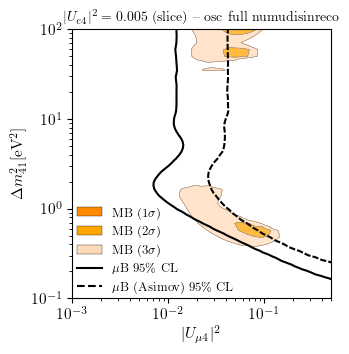

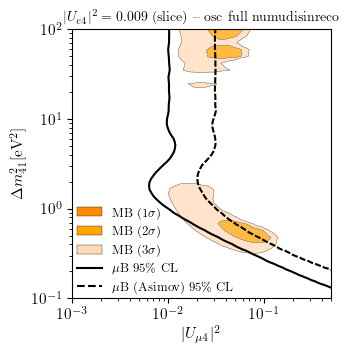

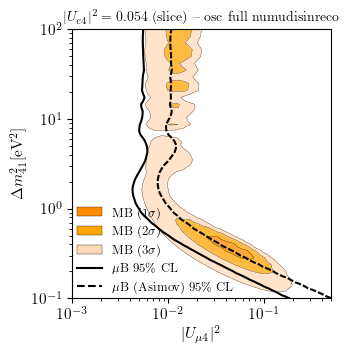

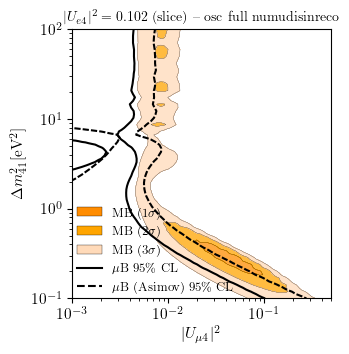

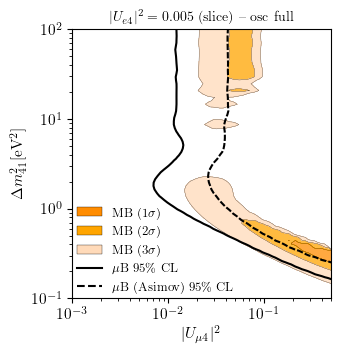

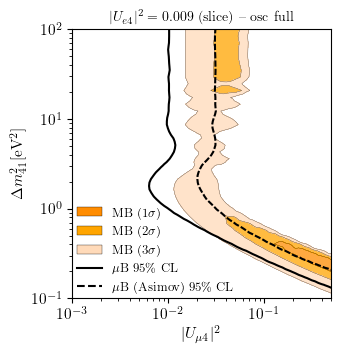

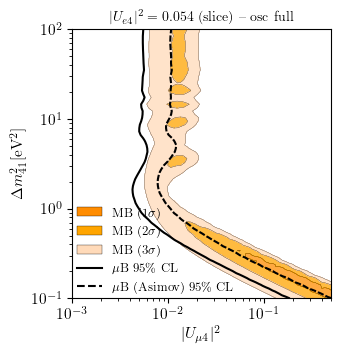

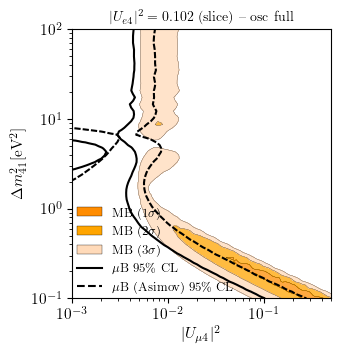

In [134]:
filenames = ['MH_osc_full_numudisinreco', 'MH_osc_full']
for filename in filenames:
    data = np.load(f"fit_data/{filename}.npy", allow_pickle=True)

    MiniApp_chi2, MicroApp_chi2, MicroApp_Asimov_chi2 = data[:,-3], data[:,-2], data[:,-1] 
    MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
    MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
    MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

    Ue4SQR, Umu4SQR, dm4SQR = data[:,2], data[:,3], data[:,1]**2


    ue4sqr_slices = [0.005, 0.01, 0.05, 0.1]
    for ue4sqr_slice in ue4sqr_slices:
        ue4sqr_slice_true = Ue4SQR[np.argmin(np.abs(Ue4SQR - ue4sqr_slice))]
        cut = (Ue4SQR == ue4sqr_slice_true)

        fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.axis([Umu4SQR[cut].min(), Umu4SQR[cut].max(), 0.1, 100])
        ax1.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
        ax1.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
        ax1.set_title(fr"$|U_{{e 4}}|^2 = {ue4sqr_slice_true:.3f}$ (slice) -- " + filename[3:].replace('_',' '), fontsize=10)

        le = len(np.unique(Umu4SQR))
        kwargs_interp = {'fine_gridx': le*2,  
                        'fine_gridy': le*2, 
                        'logx':True, 
                        'logy':True,
                        }

        X, Y, Z = pt.interp_grid(Umu4SQR[cut], dm4SQR[cut], MiniApp_deltachi2[cut], **kwargs_interp)
        cs = ax1.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
        cs = ax1.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

        X, Y, Z = pt.interp_grid(Umu4SQR[cut], dm4SQR[cut], MicroApp_deltachi2[cut], **kwargs_interp)
        cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

        X, Y, Z = pt.interp_grid(Umu4SQR[cut], dm4SQR[cut], MicroApp_Asimov_deltachi2[cut], **kwargs_interp)
        cs = ax1.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
        # ax2.scatter(sin2theta, dm4SQR, s=1)

        ax1.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
        ax1.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
        ax1.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
        ax1.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
        ax1.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B 95\% CL (Asimov)')

        ax1.legend(loc=(0,0), fontsize=9)
        fig.savefig(f"{micro.path_plots}/{filename}_slice_ue4sqr_{ue4sqr_slice_true:.3f}.pdf", bbox_inches='tight', dpi=300)